Columnas disponibles: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target']


,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores parámetros encontrados:
{'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'distance'}
Mejor R2 promedio CV: 0.9651


,rank_test_score,mean_test_score,std_test_score,mean_train_score,params
15,1,0.965064,0.008518,1.000000,"{'knn__metric': 'manhattan', 'knn__n_neighbors..."
14,2,0.964069,0.009017,0.977756,"{'knn__metric': 'manhattan', 'knn__n_neighbors..."
19,3,0.962403,0.008962,1.000000,"{'knn__metric': 'manhattan', 'knn__n_neighbors..."
17,4,0.962255,0.009638,1.000000,"{'knn__metric': 'manhattan', 'knn__n_neighbors..."
5,5,0.960183,0.010047,1.000000,"{'knn__metric': 'euclidean', 'knn__n_neighbors..."
9,6,0.959965,0.011637,1.000000,"{'knn__metric': 'euclidean', 'knn__n_neighbors..."
7,7,0.959443,0.011190,1.000000,"{'knn__metric': 'euclidean', 'knn__n_neighbors..."
18,8,0.959387,0.010095,0.969712,"{'knn__metric': 'manhattan', 'knn__n_neighbors..."
16,9,0.958975,0.011703,0.975010,"{'knn__metric': 'manhattan', 'knn__n_neighbors..."
4,10,0.958453,0.008829,0.970503,"{'knn__metric': 'euclidean', 'knn__n_neighbors..."



Evaluación sobre test_holdout -> R2: 0.9696, MSE: 0.1026


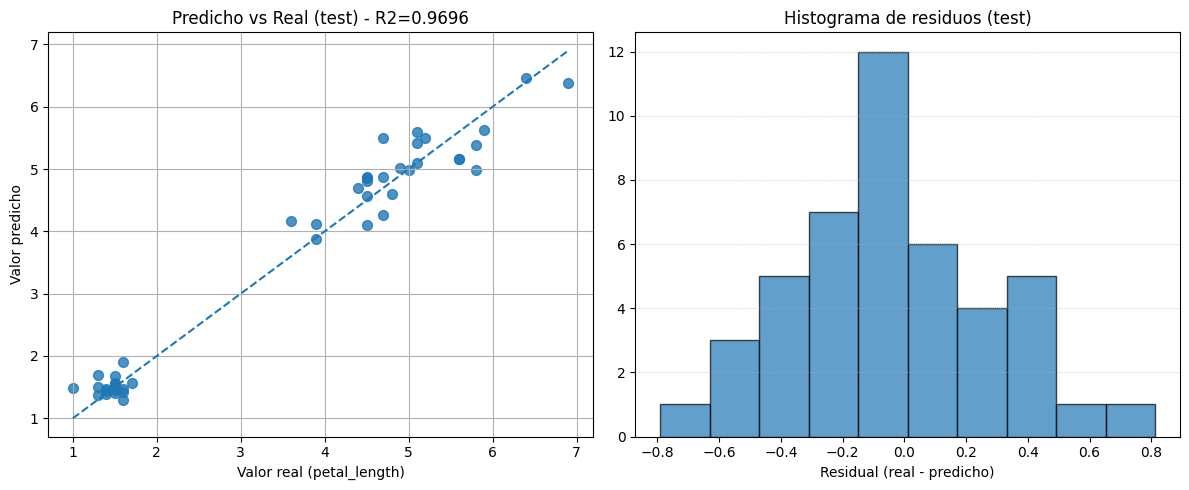

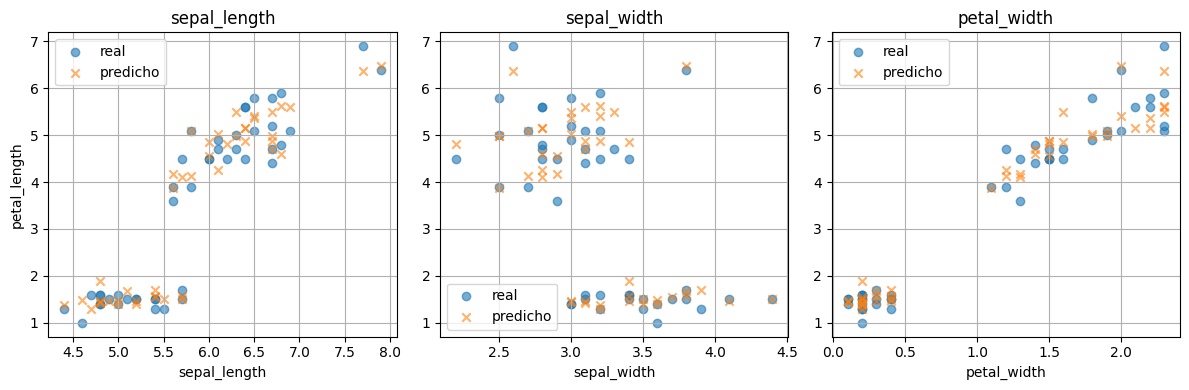

In [1]:
# -*- coding: utf-8 -*-
# Notebook: Actividad 2.20 - GridSearchCV para KNeighborsRegressor (Iris)

# 0) Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings("ignore")
RND = 42

# 1) Cargar dataset Iris (usamos la versión de sklearn)
iris = load_iris(as_frame=True)
df = iris.frame.copy()

# Ver columnas: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'target']
# Normalizamos nombres para mayor comodidad
df.columns = [c.replace(" (cm)", "").replace(" ", "_") for c in df.columns]
# El atributo objetivo será petal_length
print("Columnas disponibles:", df.columns.tolist())
display(df.head())

# 2) Preparar X, y
# Queremos predecir petal_length a partir de los otros tres atributos numéricos.
# Asegúrate de que usamos exactamente los 3 predictores solicitados.
predictors = ["sepal_length", "sepal_width", "petal_width"]
target = "petal_length"

X = df[predictors].values
y = df[target].values

# 3) Separamos un test para evaluar el modelo final
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.30, random_state=RND, shuffle=True
)

# 4) Pipeline: StandardScaler + KNeighborsRegressor
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor())
])

# 5) Grids de búsqueda (rápido vs exhaustivo)
param_grid_quick = {
    "knn__n_neighbors": [1, 3, 5, 7, 9],
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["euclidean", "manhattan"]
}

param_grid_full = {
    "knn__n_neighbors": list(range(1, 31)),   # 1..30
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["minkowski", "euclidean", "manhattan"],
    "knn__p": [1, 2],                         # relevante si metric='minkowski'
    "knn__leaf_size": [15, 30, 50]
}

# Eligir el grid:
param_grid = param_grid_quick     # cambia a param_grid_full para búsqueda más exhaustiva

# 6) CV strategy: KFold (no stratified en regresión)
cv = KFold(n_splits=5, shuffle=True, random_state=RND)

# 7) GridSearchCV - usamos scoring='r2'
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="r2",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# 8) Ejecutar búsqueda sobre train+val
gs.fit(X_trainval, y_trainval)

# 9) Resultados
print("Mejores parámetros encontrados:")
print(gs.best_params_)
print(f"Mejor R2 promedio CV: {gs.best_score_:.4f}")

results_df = pd.DataFrame(gs.cv_results_)
cols_show = ["rank_test_score", "mean_test_score", "std_test_score", "mean_train_score", "params"]
display(results_df.sort_values("rank_test_score").loc[:, cols_show].head(10))

# 10) Evaluación final sobre test_holdout con el mejor estimador
best_model = gs.best_estimator_
y_test_pred = best_model.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"\nEvaluación sobre test_holdout -> R2: {r2_test:.4f}, MSE: {mse_test:.4f}")

# 11) Visualizaciones: Predicho vs Real + Línea ideal y Residuos
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(y_test, y_test_pred, s=50, alpha=0.8)
minv = min(y_test.min(), y_test_pred.min())
maxv = max(y_test.max(), y_test_pred.max())
plt.plot([minv, maxv], [minv, maxv], linestyle='--', linewidth=1.5)  # línea y=x
plt.xlabel("Valor real (petal_length)")
plt.ylabel("Valor predicho")
plt.title(f"Predicho vs Real (test) - R2={r2_test:.4f}")
plt.grid(True)

plt.subplot(1,2,2)
residuals = y_test - y_test_pred
plt.hist(residuals, bins=10, edgecolor='k', alpha=0.7)
plt.xlabel("Residual (real - predicho)")
plt.title("Histograma de residuos (test)")
plt.grid(axis='y', linestyle=':', linewidth=0.5)

plt.tight_layout()
plt.show()

# 12) Mostrar predicción vs cada predictor para interpretar
plt.figure(figsize=(12,4))
for i, name in enumerate(predictors):
    plt.subplot(1,3,i+1)
    plt.scatter(X_test[:, i], y_test, label="real", alpha=0.6)
    plt.scatter(X_test[:, i], y_test_pred, label="predicho", alpha=0.6, marker='x')
    plt.xlabel(name)
    if i == 0: plt.ylabel("petal_length")
    plt.title(name)
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()